<a href="https://colab.research.google.com/github/ryukkt62/ktkim/blob/main/Tf_(LSTM%2CDNN)%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90%20%EC%A3%BC%EA%B0%80%20%EC%98%88%EC%B8%A1/(DNN)%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 다:1 DNN모델로 예측

In [ ]:
!pip install plot-keras-history

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9455 sha256=678288fc98beb4062cbb40a6b4e9e365f36d9a38fae7c0d32e125f1a2af0fec6
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.51-py3-none-any.whl size=321865 sha256=3e7f72897d16b65a5a719bbd5727b483bfaa30bc82974a64c9eaf27fd796baca
  Stored in directory: /root/.cache/pip/wheels/30/9f/f5/37d037c39ac8b305590d5956f7021c6ca94b63c68be24f6841
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=3b98d11efe0c7daa6761781ef9e270075e8b849a225b77301a9c5a958d435771
  Stored in directo

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

In [ ]:
# 구글 드라이브에 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# STEP 1: 데이터 Load & 전처리

In [ ]:
path ='/content/drive/MyDrive/Colab Notebooks/딥러닝으로 걷는 시계열 예측/'
kospi200 = np.load(path + 'data/kospi200.npy')
samsung = np.load(path + 'data/samsung.npy')

In [ ]:
display(kospi200.shape)
display(samsung.shape)

(426, 5)

(426, 5)

In [ ]:
samsung

array([[   53000.,    53900.,    51800.,    51900., 39565391.],
       [   52600.,    53200.,    51900.,    52600., 23104720.],
       [   52600.,    52800.,    50900.,    50900., 16128305.],
       ...,
       [   59100.,    59700.,    58800.,    59100., 16446102.],
       [   58800.,    58800.,    56800.,    57200., 20821939.],
       [   57800.,    58400.,    56400.,    56400., 19749457.]])

In [ ]:
def split_xy5(dataset,time_steps,y_column):
    x,y=list(),list()
    for i in range(len(dataset)):
        x_end_number = i+time_steps
        y_end_number = x_end_number+y_column

        if y_end_number > len(dataset):
            break

        tmp_x = dataset[i:x_end_number,:]
        tmp_y = dataset[x_end_number:y_end_number,3]

        x.append(tmp_x)
        y.append(tmp_y)
    return np.array(x),np.array(y)

# time_steps는 5개씩 학습
# y_columns은 target값이 몇번째 변수인지, 여기선 3번째 컬럼
# 5일동안의 데이터  학습 뒤 6일째 데이터 예측
x,y=split_xy5(samsung,5,1)

In [ ]:
print(x[0,:],"\n",y[0])
print(x.shape)
print(y.shape)

[[   53000.    53900.    51800.    51900. 39565391.]
 [   52600.    53200.    51900.    52600. 23104720.]
 [   52600.    52800.    50900.    50900. 16128305.]
 [   51700.    51700.    50600.    51600. 13905263.]
 [   52000.    52200.    51200.    51300. 10314997.]] 
 [50100.]
(421, 5, 5)
(421, 1)


In [ ]:
# train, test 나누기
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=1,test_size=0.3)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(294, 5, 5)
(127, 5, 5)
(294, 1)
(127, 1)


In [ ]:
# StandardScaler를 사용해서 전처리
# StandardScaler는 2차원 구조만 받으므로 reshape 필요
x_train = np.reshape(x_train,
    (x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
x_test = np.reshape(x_test,
    (x_test.shape[0], x_test.shape[1] * x_test.shape[2]))
print(x_train.shape)
print(x_test.shape)

(294, 25)
(127, 25)


In [ ]:
# StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
print(x_train_scaled[0,:])

[ 1.13392563  1.07633086  1.02393741  0.93187013 -0.028819    1.05994459
  1.04756614  1.06686328  0.94933344  1.53138774  0.79093879  0.80213886
  0.84540479  0.81507608  0.10811605  0.73712199  0.68893234  0.71073997
  0.69657856  0.37360361  0.85647275  0.80021877  0.80910994  0.69442952
 -0.16973555]


# STEP 2: 다:1모델 DNN

In [ ]:
# 모델 구성
model = Sequential()
model.add(Dense(64, input_shape=(25,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

In [ ]:
early_stopping = EarlyStopping(patience=20)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

history_model = model.fit(x_train_scaled,y_train,validation_split=0.2,verbose=1,
                          batch_size=1,epochs=100,callbacks=[early_stopping])

Epoch 1/100
235/235 [==============================] - 2s 3ms/step - loss: 1766001920.0000 - mse: 1766001920.0000 - val_loss: 787757824.0000 - val_mse: 787757824.0000
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 921046080.0000 - mse: 921046080.0000 - val_loss: 676461120.0000 - val_mse: 676461120.0000
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - loss: 833404032.0000 - mse: 833404032.0000 - val_loss: 602567616.0000 - val_mse: 602567616.0000
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 748543424.0000 - mse: 748543424.0000 - val_loss: 534146688.0000 - val_mse: 534146688.0000
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 653724288.0000 - mse: 653724288.0000 - val_loss: 477356480.0000 - val_mse: 477356480.0000
Epoch 6/100
235/235 [==============================] - 1s 2ms/step - loss: 472802112.0000 - mse: 472802112.0000 - val_loss: 346505184.0000 - val_mse: 346505184.0000
Epoch 7/

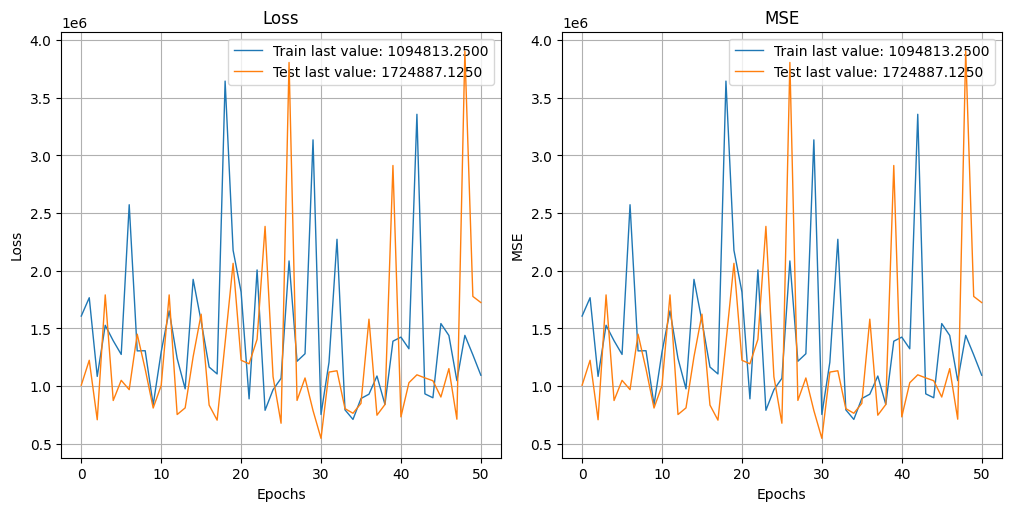

In [ ]:
plot_history(history_model.history)
plt.show()
# plot_history(model.history, path = '(hist)CNN_raw.png')
# plt.close()

In [ ]:
loss, mse = model.evaluate(x_test_scaled, y_test, batch_size=1)
print('loss: ',loss)
print('mse :', mse)

127/127 [==============================] - 0s 1ms/step - loss: 5714939.0000 - mse: 5714939.0000
loss:  5714939.0
mse : 5714939.0


In [ ]:
y_pred = model.predict(x_test_scaled)

for i in range(5):
    print('종가 : ', y_test[i], '/ 예측가 : ', y_pred[i])

4/4 [==============================] - 0s 3ms/step
종가 :  [52200.] / 예측가 :  [55334.387]
종가 :  [41450.] / 예측가 :  [38780.668]
종가 :  [49650.] / 예측가 :  [53542.723]
종가 :  [44800.] / 예측가 :  [46407.96]
종가 :  [49500.] / 예측가 :  [51599.504]
